# Predictions Based on Third Year Data

## Dependencies

In [1]:
using DataFrames, DataArrays, Gadfly, Distributions, GLM

In [2]:
set_default_plot_size(985px, 400px);

## Preparing the Data

This data contains all years up to 2014

In [3]:
data = readtable("begfresh2.csv");

Load students that were admitted after 2005 and before 2015.

In [4]:
data = data[data[:ENTRYSEM] .>= 20063, :];

Transform entry year column (ex 20063 to 2006).

In [5]:
data[:ENTRYSEM] .-= 3;
data[:ENTRYSEM] ./= 10;

Convert NA values to 0

In [6]:
data[isna(data[:CUMGPA06]), :CUMGPA06] = 0;
data[isna(data[:CUMHRS06]), :CUMHRS06] = 0;
data[isna(data[:GRAD4]), :GRAD4] = 0;
data[isna(data[:GRAD5]), :GRAD5] = 0;
data[isna(data[:GRAD6]), :GRAD6] = 0;

Number of students:

In [7]:
students = size(data)[1]

32139

## Four Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will graduate within four years. The following features are used in this model:
- Whether the student is male
- Whether the student is American Indian
- Sixth semester GPA
- Number of credit hours after the sixth semester
- Number of major changes

In [8]:
training_4year = data[data[:ENTRYSEM] .<= 2011, :];

In [9]:
gradmodel_4years = glm(GRAD4 ~ MALE + AM_INDIAN + CUMGPA06 + CUMHRS06 + CHANGE_3, training_4year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
              Estimate  Std.Error  z value Pr(>|z|)
(Intercept)   -6.69301   0.133649  -50.079   <1e-99
MALE         -0.108332  0.0286323 -3.78357   0.0002
AM_INDIAN    -0.307582  0.0856541 -3.59098   0.0003
CUMGPA06      0.897168  0.0334358  26.8326   <1e-99
CUMHRS06     0.0366431 0.00115641  31.6869   <1e-99
CHANGE_3     -0.428195  0.0363751 -11.7717   <1e-31


### Make Predictions Using the Training Model

In [10]:
year = 2006;
years = [];
actual_4year = [];
predicted_4year = [];

for i=1:7
    X = data[data[:ENTRYSEM] .== year, :]
    probs = predict(gradmodel_4years, X)
    push!(predicted_4year, mean(probs)*100)
    year <= 2011 ? push!(actual_4year, mean(X[:GRAD4])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [11]:
rmse = sqrt(sum((predicted_4year[1:6]-actual_4year).^2)) / 6

0.6467023025137494

#### Plot

In [12]:
theme_predicted = Theme(default_color=colorant"red")
layer_predicted_4year = layer(x=years, y=predicted_4year, Geom.point, Geom.line, theme_predicted);

In [13]:
theme_actual = Theme(default_color=colorant"blue")
layer_actual_4year = layer(x=years[1:6], y=actual_4year, Geom.point, Geom.line, theme_actual);

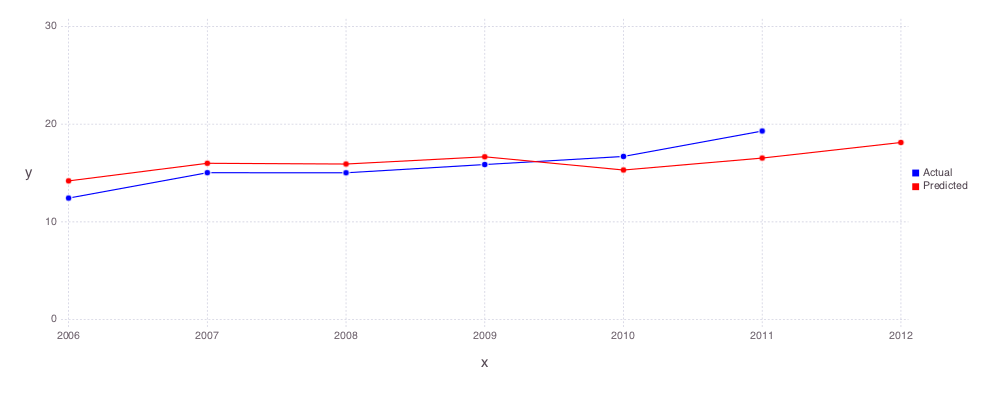

In [14]:
plot(layer_predicted_4year, layer_actual_4year, Coord.Cartesian(ymin=0,ymax=30), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

## Five Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will graduate within four years. The following features are used in this model:
- ACTCOMPSQ
- Whether the student is male
- Whether the student is American Indian
- Sixth semester GPA
- Number of credit hours after the sixth semester
- FOUR_YR3

In [15]:
training_5year = data[data[:ENTRYSEM] .<= 2010, :];

In [16]:
gradmodel_5years = glm(GRAD5 ~ MALE + AM_INDIAN + CUMGPA06 + CUMHRS06 + FOUR_YR3, training_5year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
              Estimate  Std.Error  z value Pr(>|z|)
(Intercept)   -6.51752   0.202688 -32.1555   <1e-99
MALE         -0.122218  0.0293475 -4.16452    <1e-4
AM_INDIAN    -0.219267  0.0728366  -3.0104   0.0026
CUMGPA06       1.07854  0.0472096  22.8457   <1e-99
CUMHRS06     0.0395976 0.00139404  28.4051   <1e-99
FOUR_YR3      0.672983    0.16291  4.13102    <1e-4


### Make Predictions Using the Training Model

In [17]:
year = 2006;
years = [];
actual_5year = [];
predicted_5year = [];

for i=1:7
    X = data[data[:ENTRYSEM] .== year, :]
    X = X[!isna(X[:FOUR_YR3]), :]
    probs = predict(gradmodel_5years, X)
    push!(predicted_5year, mean(probs)*100)
    year <= 2010 ? push!(actual_5year, mean(X[:GRAD5])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [18]:
rmse = sqrt(sum((predicted_5year[1:5]-actual_5year).^2)) / 5

0.3035888062830265

#### Plot

In [19]:
theme_predicted = Theme(default_color=colorant"red")
layer_predicted_5year = layer(x=years, y=predicted_5year, Geom.point, Geom.line, theme_predicted);

In [20]:
theme_actual = Theme(default_color=colorant"blue")
layer_actual_5year = layer(x=years[1:5], y=actual_5year, Geom.point, Geom.line, theme_actual);

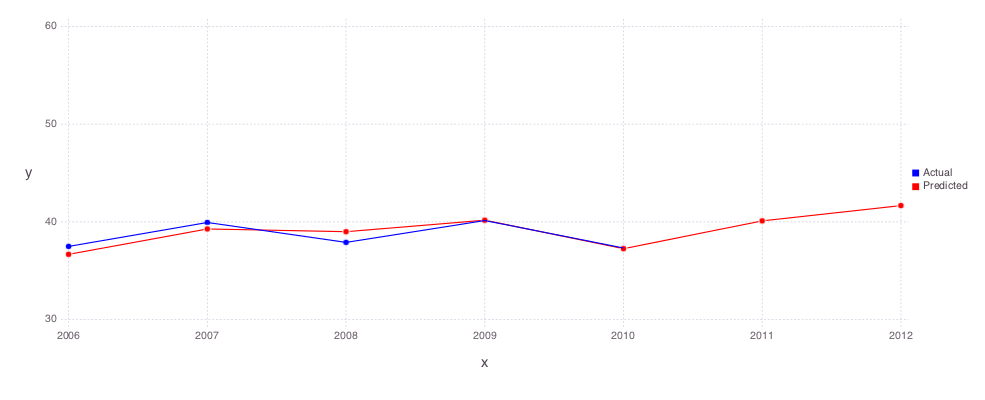

In [21]:
plot(layer_predicted_5year, layer_actual_5year, Coord.Cartesian(ymin=30,ymax=60), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

## Six Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will graduate within four years. The following features are used in this model:
- ACTCOMPSQ
- Whether the student is American Indian
- Sixth semester GPA
- Number of credit hours after the sixth semester
- Number of major changes
- FIVE_YR3

In [22]:
training_6year = data[data[:ENTRYSEM] .<= 2009, :];

In [23]:
gradmodel_6years = glm(GRAD6 ~ ACTCOMPSQ + AM_INDIAN + CUMGPA06 + CUMHRS06 + CHANGE_3 + FIVE_YR3, training_6year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
                 Estimate  Std.Error  z value Pr(>|z|)
(Intercept)      -3.62638   0.186491 -19.4453   <1e-83
ACTCOMPSQ    -0.000464771 9.70648e-5 -4.78825    <1e-5
AM_INDIAN       -0.245839  0.0743756 -3.30537   0.0009
CUMGPA06         0.536254  0.0522164  10.2699   <1e-24
CUMHRS06        0.0219823 0.00163809  13.4194   <1e-40
CHANGE_3          0.20048    0.03742  5.35756    <1e-7
FIVE_YR3          1.80676   0.147304  12.2655   <1e-33


### Make Predictions Using the Training Model

In [24]:
year = 2006;
years = [];
actual_6year = [];
predicted_6year = [];

for i=1:7
    X = data[data[:ENTRYSEM] .== year, :]
    X = X[!isna(X[:FIVE_YR3]), :]
    probs = predict(gradmodel_6years, X)
    push!(predicted_6year, mean(probs)*100)
    year <= 2009 ? push!(actual_6year, mean(X[:GRAD6])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [25]:
rmse = sqrt(sum((predicted_6year[1:4]-actual_6year).^2)) / 4

0.13693673195717743

#### Plot

In [26]:
theme_predicted = Theme(default_color=colorant"red")
layer_predicted_6year = layer(x=years, y=predicted_6year, Geom.point, Geom.line, theme_predicted);

In [27]:
theme_actual = Theme(default_color=colorant"blue")
layer_actual_6year = layer(x=years[1:4], y=actual_6year, Geom.point, Geom.line, theme_actual);

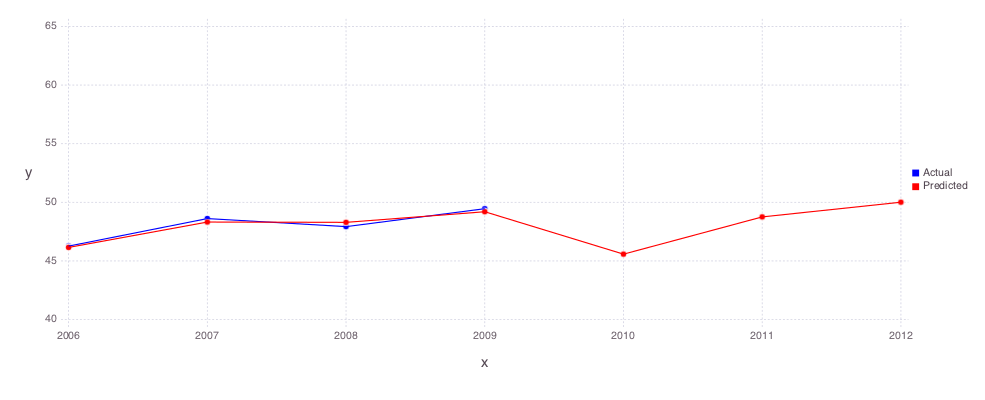

In [28]:
plot(layer_predicted_6year, layer_actual_6year, Coord.Cartesian(ymin=40,ymax=65), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))